# Imports

In [10]:
from model_encoder.encoder import ModelEncoder
from model_encoder.operations import *
from model_encoder.data_loaders import load_cifar
import numpy as np
import torch
import torch.optim as optim

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model Building
Here, we'll walk through the process of building a model via model encoding. In this example, we'll create something reminiscient of a ResNet and train it on CIFAR10.

## Define Available Operations
First, we need to establish the available operations for use within the model. We'll use some of the prepackaged operations in model_encoder.operations, but we'll also define two custom ones. To build an operation, we need to pass `build_operation` three things:

* `name`: a string that uniquely refers to the operation
* `function`: An initialization function for the operation. This takes the form of some function f(c) that when supplied a channel size returns an initialized PyTorch module.
* `mod`: The dimensionality modification factors. These describe how the operation affects the channel, height, and width dimensions of tensors flowing through it, and we supply it as tuple in the format `[C,H,W]`.
<br><br>
Our first operation, `Reducer`, will double channel dimensions and halve spatial dimensions, whereas our second, `Scaler`, will simply double channel dimensions.
<br><br>
Once we have all the operations we need, we'll pass that list into `build_operation_set`, which shows us a little reference to our operation set for use later when we're building the model.

In [8]:
Reducer = build_operation(name='Reducer', 
                          function=lambda c: conv2d(c, c * 2, k=3, s=2), 
                          mod=[2, .5, .5])
Scaler  = build_operation(name='Scaler',  
                          function=lambda c: conv2d(c, c * 2, k=1), 
                          mod=[2, 1, 1])

operation_set = build_operation_set(
    Identity, 
    ReLU, 
    BatchNorm,
    Conv3x3,
    Reducer,
    Scaler
)

 i |      Name       | *C  | *H  | *W  |
----------------------------------------
 0 | Identity        |  1  |  1  |  1  |
 1 | ReLU            |  1  |  1  |  1  |
 2 | BatchNorm       |  1  |  1  |  1  |
 3 | Conv3x3         |  1  |  1  |  1  |
 4 | Reducer         |  2  | 0.5 | 0.5 |
 5 | Scaler          |  2  |  1  |  1  |


## Define Some Cells
Next, we'll create some cells to use in our model. The easiest way to create cells are via dictionaries, where the keys are tuples referring to edges in the cell, and the values are the list of operations that exist along that edge. For example, `(0,1): ['Identity', 'Conv3x3']` refers to the edge between Node 0 and Node 1, and places both an Identity and 3x3 Convolution along that edge.
<br><br>
We'll create three cells, an upscaling cell to upscale the input data to a larger channel dimension, a normal cell, and a reduction cell. Notice that we ensure that each cell has the same number of nodes (7), as necessitated by the largest cell, the reduction.
<br><br>
Let's take a look at the reduction cell, via `operations.cell_visualizer`

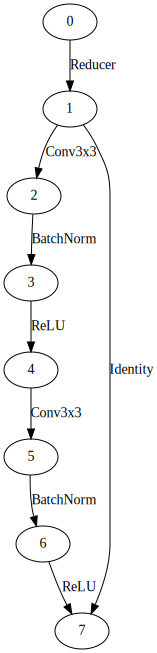

In [11]:
upscaling_cell = {
    (0,1): ['Scaler'],
    (1,2): ['Scaler'],
    (2,3): ['Scaler'],
    (3,4): ['Scaler'],
    (4,7): ['Scaler'],
}

normal_cell = {
    (0,2): ['Conv3x3'],
    (2,3): ['BatchNorm'],
    (3,4): ['ReLU'],
    (4,5): ['Conv3x3'],
    (5,6): ['BatchNorm'],
    (6,7): ['ReLU'],
    (0,7): ['Identity'],
}

reduction_cell = {
    (0,1): ['Reducer'],
    (1,2): ['Conv3x3'],
    (2,3): ['BatchNorm'],
    (3,4): ['ReLU'],
    (4,5): ['Conv3x3'],
    (5,6): ['BatchNorm'],
    (6,7): ['ReLU'],
    (1,7): ['Identity']
}
cell_visualizer(reduction_cell)

## Construct Model
Finally, we can build our model. The easiest way to do this is via a model structure dictionary, where the keys are cell number and the values are the cell dictionaries as described above. Once we've created the structure dictionary, we can pass it to `ModelEncoder.adj_from_dict` along with our operation set to create the adjacency matrix for this particular structure. Alternatively, we could have just hand-written the 4D adjacency, but that'd be a pain. 
<br><br>
We'll also need to define an output function for our model, which defines how the function that takes the last cell's output and transforms it into the shape we want. The operations module contains sample Classifier and Regression functions, so for our purposes we'll use the Classifier. To do this, we pass the Classifier into `build_output` and specify the length of the output vector we need. For CIFAR10, we have 10 classes, so we'll choose 10 for our output size.

In [ ]:
model_structure = {
    0: upscaling_cell,
    1: normal_cell,
    2: normal_cell,
    3: reduction_cell,
    4: normal_cell,
    5: normal_cell,
    6: reduction_cell,
    7: normal_cell,
    8: normal_cell
}
adj = ModelEncoder.adj_from_dict(model_structure, operation_set)
output_function = build_output(Classifier, output_size=10)

Now we've got everything we need to create our model, so we'll load the data from `model_encoder.data_loaders.load_cifar` and build our model. The ModelEncoder constructor needs five arguments:
* `input_dim`: the dimensionality of each tensor input. In our case, it's `[64,3,32,32]`
* `adjacency`: the adjacency matrix of the model
* `operation_set`: the set of operations referred to by the adjacency matrix
* `output_function`: the output function of the model
* `device`: the torch.device to put the model onto
<br><br>

The ModelEncoder will dynamically compute all the tensor dimensionalities throughout the model and intialize parameters accordingly. If the tensor dimensions cannot align (say, for example, an Identity and an Upscaler that share origin and target nodes) then ModelEncoder will raise an error.

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
(train_loader, test_loader), dim = load_cifar(batch_size=64)
me = ModelEncoder(input_dim=dim,
                  adjacency=adj,
                  operation_set=operation_set,
                  output_function=output_function,
                  device=device)

# Define Training and Testing Functions
These are just slightly modified versions of the train and test functions from PyTorch's [CIFAR10 Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [ ]:
def train(model, optimizer, criterion, dataloader, device):
    running_loss = 0.0
    dl_len = len(dataloader)
    for i, (x,y) in enumerate(dataloader, 0):
        if i%10==0 or i+1==dl_len:
            print("\r  Train Batch: {:>4}/{:<4}".format(i+1, dl_len), end="")
        
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
            
def test(model, dataloader, device):
    correct = 0
    total = 0
    with torch.no_grad():
        for (x,y) in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    print("| Test Accuracy: {:.2f}%".format(correct/len(dataloader.dataset)*100))

# Train Model
And now we can train our model!

In [ ]:
epochs = 16
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(me.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
for epoch in range(epochs):
    print("== EPOCH {} ==".format(epoch))
    train(me, optimizer, criterion, train_loader, device)
    test(me, test_loader, device)
    scheduler.step()

== EPOCH 0 ==
  Train Batch:  782/782 | Test Accuracy: 48.30%
== EPOCH 1 ==
  Train Batch:  782/782 | Test Accuracy: 52.49%
== EPOCH 2 ==
  Train Batch:  782/782 | Test Accuracy: 55.27%
== EPOCH 3 ==
  Train Batch:  782/782 | Test Accuracy: 57.87%
== EPOCH 4 ==
  Train Batch:  782/782 | Test Accuracy: 58.49%
== EPOCH 5 ==
  Train Batch:  782/782 | Test Accuracy: 60.40%
== EPOCH 6 ==
  Train Batch:  782/782 | Test Accuracy: 60.52%
== EPOCH 7 ==
  Train Batch:  782/782 | Test Accuracy: 62.00%
== EPOCH 8 ==
  Train Batch:  782/782 | Test Accuracy: 62.22%
== EPOCH 9 ==
  Train Batch:  782/782 | Test Accuracy: 62.68%
== EPOCH 10 ==
  Train Batch:  782/782 | Test Accuracy: 62.69%
== EPOCH 11 ==
  Train Batch:  782/782 | Test Accuracy: 63.28%
== EPOCH 12 ==
  Train Batch:  782/782 | Test Accuracy: 63.50%
== EPOCH 13 ==
  Train Batch:  782/782 | Test Accuracy: 63.77%
== EPOCH 14 ==
  Train Batch:  782/782 | Test Accuracy: 63.70%
== EPOCH 15 ==
  Train Batch:  782/782 